# Project - Predicting Car Prices with K-nearest Neighbors

**Background and Introduction**: In this project, we will apply the machine learning algorithm K-nearest Neighbours or KNN to a practical problem i.e. prediction of car prices. K nearest neighbors is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).

**Dataset**: The dataset being used is taken from the [UCI Machine Learning Laboratory](https://archive.ics.uci.edu/ml/datasets/automobile) and has 205 entries containing information on various attributes on imported cars. This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

**Prediction Strategy**: Since we are interested in predicting car prices based on available data, we will follow following strategy:
- Cleaning and normalizing the data.
- Selection of features most likely to impact car prices.
- Selection of k values
- Model selection using k-fold cross-validation

We will use the Python machine learning scikitlearn for model training and predicitons.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# Setting pandas display options for large data
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

### Data Cleaning and Normalizing
The dataset comes without column names which are contained in a separate file and have to be provided while reading the dataset.

In [2]:
# The data set comes with an accompanying name file from which column names can be extracted
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names = cols)
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

   ### Missing Entries
   
   According to the accompanying file `import-85.names` which contains information on the respective attributes, following columns contain the number of missing entries as shown against their column number:
   
   >
   
       2.             41
       6.             2
       19.            4
       20.            4
       22.            2
       23.            2
       26.            4
>

These missing values are plugged in with the string '?' in the dataframe. First we will need to replace it with NAN in order to convert the numeric columns to the appropriate type.

In [4]:
cars = cars.replace('?', np.nan).copy()
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

### Numeric Columns

Since we can only work with numeric columns with continuous values we will only keep the required columns and remove the rest from our dataset. We have the required information on continuous variables from the accompanying file `imports-85.names`. We will retain the numeric columns, convert them to `dtype: float`, drop any `NAN` values from the `price` column, fill the remaining missing values with average values for that variable, and convert all columns to normalized values i.e. on a scale from `0` to `1` except the `price` column. 

In [5]:
continuous_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 
                'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
continuous_cars = cars[continuous_cols].astype('float')
continuous_cars = continuous_cars.dropna(subset = ['price']).copy()
continuous_cars = continuous_cars.fillna(continuous_cars.mean()).copy()
normalized_cars = (continuous_cars - continuous_cars.min()) / (continuous_cars.max() - continuous_cars.min())
normalized_cars['price'] = continuous_cars['price']
normalized_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  201 non-null    float64
 1   wheel-base         201 non-null    float64
 2   length             201 non-null    float64
 3   width              201 non-null    float64
 4   height             201 non-null    float64
 5   curb-weight        201 non-null    float64
 6   engine-size        201 non-null    float64
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-rate   201 non-null    float64
 10  horsepower         201 non-null    float64
 11  peak-rpm           201 non-null    float64
 12  city-mpg           201 non-null    float64
 13  highway-mpg        201 non-null    float64
 14  price              201 non-null    float64
dtypes: float64(15)
memory usage: 25.1 KB


In [6]:
normalized_cars.describe()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.298429,0.355598,0.494045,0.477697,0.497222,0.414145,0.248587,0.564793,0.565192,0.197767,0.258864,0.394934,0.338308,0.386489,13207.129353
std,0.167520,0.176862,0.183913,0.179613,0.203985,0.200658,0.156781,0.191480,0.150499,0.250310,0.174606,0.195148,0.178423,0.179346,7947.066342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5118.000000
25%,0.188482,0.230321,0.383582,0.324786,0.350000,0.264158,0.139623,0.435714,0.495238,0.100000,0.102804,0.265306,0.166667,0.236842,7775.000000
50%,0.298429,0.303207,0.479104,0.444444,0.525000,0.359193,0.222642,0.550000,0.580952,0.125000,0.219626,0.394934,0.305556,0.368421,10295.000000
75%,0.376963,0.460641,0.632836,0.538462,0.641667,0.557797,0.301887,0.742857,0.638095,0.150000,0.317757,0.551020,0.472222,0.473684,16500.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45400.000000


### Function for Univariate and Multivariate KNN Regression
We will now write a general purpose function to split the above data into training and test datasets and predict prices for the test datasets for both the univariate and multivariate cases for any number of k values. First, we will randomize the dataset.

In [7]:
# randomize data once
# Don't rerun the complete kernel after randomization as it will change results
normalized_cars = normalized_cars.loc[np.random.permutation(normalized_cars.index)]
normalized_cars = normalized_cars.reset_index(drop = True)

In [8]:
# Function for univariate and multivariate cases with varying k
def knn_train_test(k, df, features_train, feature_target, n_splits = 0.75 ):
    """ Trains the model and predicts root mean squared error(RMSE) values for target feature 
    Args:
    k(int):range of k nearest neighbors (from 1 to k)
    df (matrix, dataframe): dataframe like or matrix like
    features_train(array like): df features to train the model on
    feature_target(array like): target df feature
    n_splits(float): How to split the df into training and test sets
    Returns:
    Array: RMSE values for the range of k nearest neighbors specified
    """
    
    train_df = df.head(int(len(df.index)*n_splits)+1)
    test_df = df.tail(int(len(df.index)*(1-n_splits)))
    
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_squared_error
    hyper_params = [param for param in range(1, k+1)]
    mse_values = []
    rmse_values = []
    for param in hyper_params:
        knn = KNeighborsRegressor(n_neighbors = param, algorithm = 'brute')
        train_features = train_df[features_train]
        train_target = train_df[feature_target]
        knn.fit(train_features, train_target)
        predictions = knn.predict(test_df[features_train])
        y_true = test_df[feature_target]
        y_pred = predictions
        mse = mean_squared_error(y_true, y_pred)
        rmse = mse ** (1/2)
        mse_values.append(mse)
        rmse_values.append(rmse)
    return rmse_values      


### Feature Selection - Univariate Cases

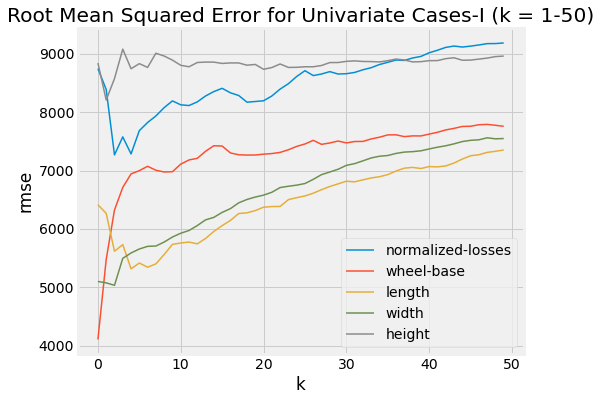

In [9]:
train = normalized_cars.columns[0:5]
target = ['price']
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
for col in train:
    plt.plot(knn_train_test(50, normalized_cars, [col], target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend()
plt.title('Root Mean Squared Error for Univariate Cases-I (k = 1-50)')
plt.show()

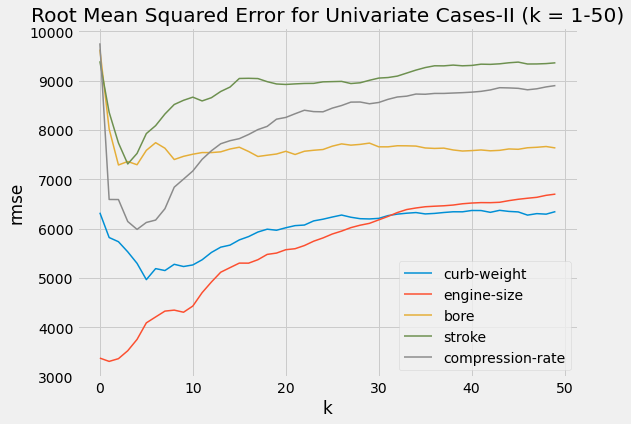

In [10]:
train = normalized_cars.columns[5:10]
target = ['price']
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
for col in train:
    plt.plot(knn_train_test(50, normalized_cars, [col], target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend()
plt.title('Root Mean Squared Error for Univariate Cases-II (k = 1-50)')
plt.show()

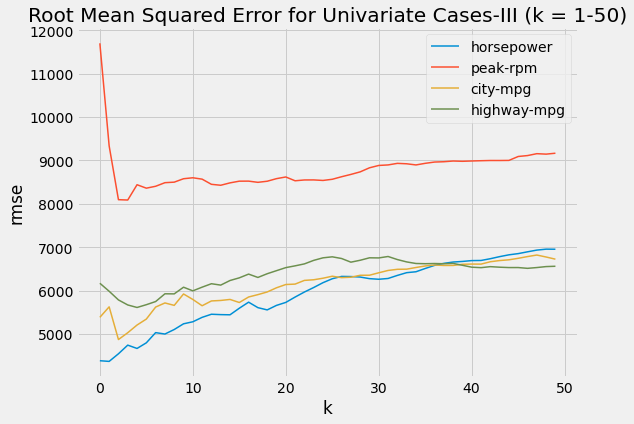

In [11]:
train = normalized_cars.columns[10:-1]
target = ['price']
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
for col in train:
    plt.plot(knn_train_test(50, normalized_cars, [col], target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend()
plt.title('Root Mean Squared Error for Univariate Cases-III (k = 1-50)')
plt.show()

### Univariate Cases - Conclusions
It is quite clear from above plots that out of 14 features analyzed individually for k values between 1-50, approx half i.e. 7 features converge around a root mean squared error of between 5000 and 60000 after k>20. For all these features minimas occur at a k value of less than 10 at around between 3000 to 50000. These error values are considerably high given that we have seen abouve using `normalized_cars.describe()` that the mean price is approximately `13000`, the minimum price is close to `5000` and the maximum price is about `45,000`. We will also drop the `8` high-price features and consider only the `6` `low-price` cases. These `low-price` features are plotted together below for  k values of 1-5, 1-10 and 1-20 to highlight the differences.

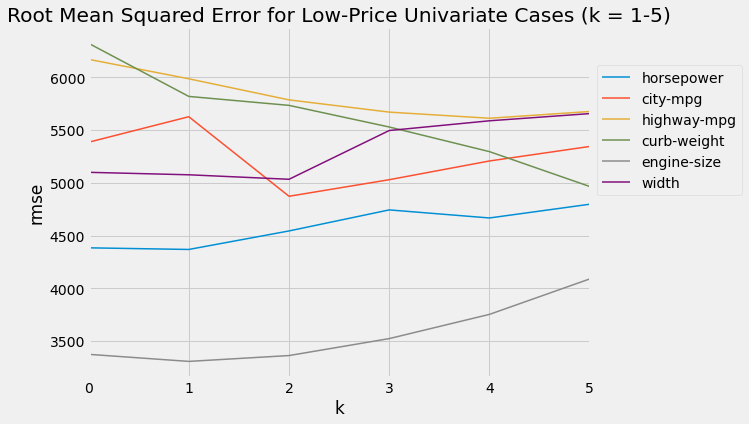

In [12]:
# low-price features plotted together k = 1-5
low_price = ['horsepower', 'city-mpg', 'highway-mpg', 'curb-weight', 'engine-size', 'width']
target = ['price']
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
for col in low_price:
    plt.plot(knn_train_test(6, normalized_cars, [col], target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend(loc = 'lower left', bbox_to_anchor=(1, 0.5))
plt.title('Root Mean Squared Error for Low-Price Univariate Cases (k = 1-5)')
plt.xlim(0, 5)
plt.show()

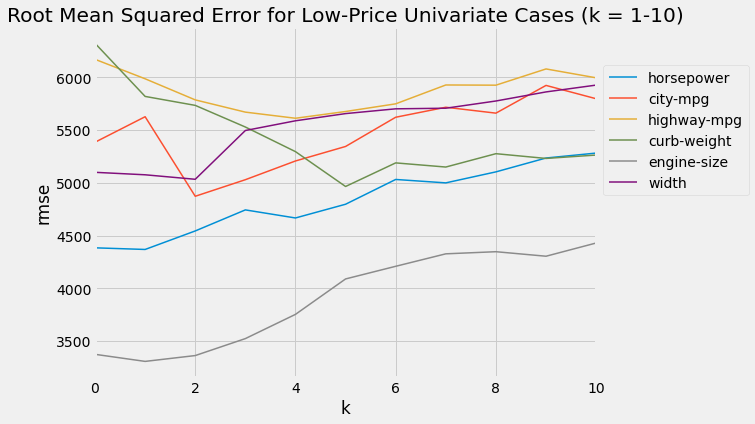

In [13]:
# low-price features plotted together k = 1-10
low_price = ['horsepower', 'city-mpg', 'highway-mpg', 'curb-weight', 'engine-size', 'width']
target = ['price']
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
for col in low_price:
    plt.plot(knn_train_test(11, normalized_cars, [col], target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend(loc = 'lower left', bbox_to_anchor=(1, 0.5))
plt.title('Root Mean Squared Error for Low-Price Univariate Cases (k = 1-10)')
plt.xlim(0, 10)
plt.show()

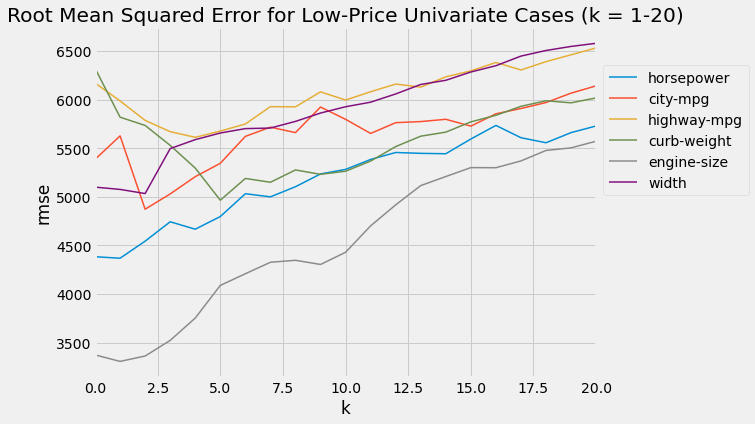

In [15]:
# low-price features plotted together k = 1-20
low_price = ['horsepower', 'city-mpg', 'highway-mpg', 'curb-weight', 'engine-size', 'width']
target = ['price']
fig = plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')
for col in low_price:
    plt.plot(knn_train_test(21, normalized_cars, [col], target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend(loc = 'lower left', bbox_to_anchor=(1, 0.5))
plt.title('Root Mean Squared Error for Low-Price Univariate Cases (k = 1-20)')
plt.xlim(0, 20)
plt.show()

### Multivariate Cases

It is obvious from above plots that lowest values for all the `low-price` feature converge at a k-value of around 5. We will now consider these features together in the following combination:
- `order`: Lowest RMSE to highest RMSE
- No of features: 2 to 6

Firse, we will define a function to get the `k` value for the minimum RMSE for each of the six features isolated above.

In [16]:

def knn_rmse_min(k, df, features_train, feature_target, n_splits = 0.75 ):
    """ Trains the model, predicts root mean squared error(RMSE) values for target feature 
    and determines k-nearest neighbors value for which RMSE is minimum
    Args:
    k(int):range of k nearest neighbors (from 1 to k)
    df (matrix, dataframe): dataframe like or matrix like
    features_train(array like): df features to train the model on
    feature_target(array like): target df feature
    n_splits(float): How to split the df into training and test sets
    Returns:
    dict: minimum RMSE value with k value as key
    """
    train_df = df.head(int(len(df.index)*n_splits)+1)
    test_df = df.tail(int(len(df.index)*(1-n_splits)))
    
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_squared_error
    hyper_params = [r for r in range(1, k+1)]
    mse_values = []
    rmse_values = []
    min_dictionary = {}
    min_k = {}
    for param in hyper_params:
        knn = KNeighborsRegressor(n_neighbors = param, algorithm = 'brute')
        train_features = train_df[features_train]
        train_target = train_df[feature_target]
        knn.fit(train_features, train_target)
        predictions = knn.predict(test_df[features_train])
        y_true = test_df[feature_target]
        y_pred = predictions
        mse = mean_squared_error(y_true, y_pred)
        rmse = mse ** (1/2)
        mse_values.append(mse)
        rmse_values.append(rmse)
        min_dictionary[param] = rmse
    min_rmse_key = min(min_dictionary, key=lambda param: min_dictionary[param])
    min_k[min_rmse_key] = min(rmse_values) 
    return min_k

In [22]:
# low-price features min knn values k = 1-50
low_price = ['horsepower', 'city-mpg', 'highway-mpg', 'curb-weight', 'engine-size', 'width']
target = ['price']
for col in low_price:
    min_k = knn_rmse_min(50, normalized_cars, [col], target, n_splits = 0.75 )
    print(min_k)

{2: 4368.918995586895}
{3: 4872.768931293354}
{5: 5611.89955526647}
{6: 4965.435532928272}
{2: 3308.477266054582}
{3: 5033.73003271155}


### Selecting knn values and Feature order for Multivariate Cases

From above, it can be seen that the minimum knn values for all selected features are below `6`. We are not as yet bound to select a knn value as our functions are flexible enough to carry out `hyperparameter-optimiztion` on the go. However, we will consider multivariate cases in the following order from first two to first six features:
```
low_price = ['engine-size', 'horsepower`, `city-mpg`, `curb-weight`, `width`, `highway-mpg`]

```

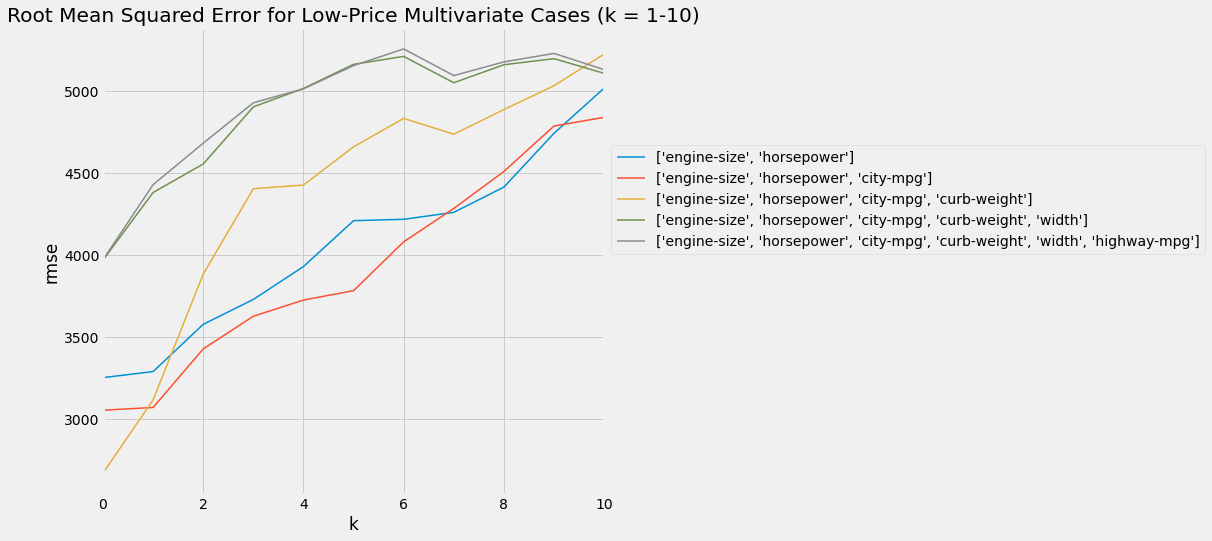

In [34]:
# All multivariate combinations, plotted together
low_price = ['engine-size', 'horsepower', 'city-mpg', 'curb-weight', 'width', 'highway-mpg']
first_two_features = low_price[0:2]
first_three_features = low_price[0:3]
first_four_features = low_price[0:4]
first_five_features = low_price[0:5]
six_features = low_price 
low_price_features = [first_two_features, first_three_features, first_four_features, first_five_features, six_features]             
target = ['price']
fig = plt.figure(figsize=(8, 8))
plt.style.use('fivethirtyeight')
for col in low_price_features:
    plt.plot(knn_train_test(11, normalized_cars, col, target), label = col, linewidth = 1.5)
plt.xlabel("k")
plt.ylabel('rmse')
plt.legend(loc = 'lower left', bbox_to_anchor=(1, 0.5))
plt.title('Root Mean Squared Error for Low-Price Multivariate Cases (k = 1-10)')
plt.xlim(0, 10)
plt.show()             

### Hyperparameter Optimization I - Determining the Minimum knn
We can see above that for multivariate cases, RMSE is increasing with increase in k value which means that we will have to look at the distribution of training and test sets more closely through a `k-fold` analysis. However, first let us determine minimum knn values for all the five models above.

In [37]:
# Determine minimum knn for all five models

low_price_features = [first_two_features, first_three_features, first_four_features, first_five_features, six_features]             
target = ['price']

for col in low_price_features:
    min_k = knn_rmse_min(50, normalized_cars, col, target, n_splits = 0.75 )
    print(min_k)

{1: 3253.8129018122722}
{1: 3055.242167161222}
{1: 2671.9910890569977}
{1: 3970.2814534992353}
{1: 3972.552886998485}


### Hyperparameter Optimization II - Determining the Maximum knn

Above values show that invariably, for all five models RMSE is increasing as the knn value is increased. Let's determine maximum knn values. We will write a function for that.

In [38]:

def knn_rmse_max(k, df, features_train, feature_target, n_splits = 0.75 ):
    """ Trains the model, predicts root mean squared error(RMSE) values for target feature 
    and determines k-nearest neighbors value for which RMSE is maximum
    Args:
    k(int):range of k nearest neighbors (from 1 to k)
    df (matrix, dataframe): dataframe like or matrix like
    features_train(array like): df features to train the model on
    feature_target(array like): target df feature
    n_splits(float): How to split the df into training and test sets
    Returns:
    dict: maximum RMSE value with k value as key
    """
    train_df = df.head(int(len(df.index)*n_splits)+1)
    test_df = df.tail(int(len(df.index)*(1-n_splits)))
    
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.metrics import mean_squared_error
    hyper_params = [r for r in range(1, k+1)]
    mse_values = []
    rmse_values = []
    max_dictionary = {}
    max_k = {}
    for param in hyper_params:
        knn = KNeighborsRegressor(n_neighbors = param, algorithm = 'brute')
        train_features = train_df[features_train]
        train_target = train_df[feature_target]
        knn.fit(train_features, train_target)
        predictions = knn.predict(test_df[features_train])
        y_true = test_df[feature_target]
        y_pred = predictions
        mse = mean_squared_error(y_true, y_pred)
        rmse = mse ** (1/2)
        mse_values.append(mse)
        rmse_values.append(rmse)
        max_dictionary[param] = rmse
    max_rmse_key = max(max_dictionary, key=lambda param: max_dictionary[param])
    max_k[max_rmse_key] = max(rmse_values) 
    return max_k

In [39]:
low_price_features = [first_two_features, first_three_features, first_four_features, first_five_features, six_features]             
target = ['price']

for col in low_price_features:
    max_k = knn_rmse_max(50, normalized_cars, col, target, n_splits = 0.75 )
    print(max_k)

{50: 6535.6889687842395}
{50: 6600.717875863504}
{50: 6355.602234909922}
{50: 6362.965983904047}
{50: 6381.51419476287}


### K-fold Cross-Validation

Above confirms that the RMSE is constantly rising for all five models as the knn value is increased from 1 to 50 which is not an expected behaviour. This is most likely due to an off-chance randomization. So, we will conduct a k-fold cross-validation for all five models with folds = 2 to 10 to see which distribution can best optimize the data splitting between training and test sets.

**We will write a function for that**.

In [46]:
def kfold_avg_rmse(k, df, features_train, feature_target, n_splits = 5 ):
    """ Trains the model, predicts root mean squared error(RMSE) values for target feature 
    and determines average rmse and std deviation for the number of folds(n_splits)
    Args:
    k(int):range of k nearest neighbors (from 1 to k)
    df (matrix, dataframe): dataframe like or matrix like
    features_train(array like): df features to train the model on
    feature_target(array like): target df feature
    n_splits(int): number of folds
    Returns:
   list: average rmse for n_splits specified, average Std dev for n_splits specified
    """

    from sklearn.model_selection import cross_val_score, KFold
    
    num_folds = [fold for fold in range(2, n_splits+1)]
    average_rmse_allfolds = []
    average_sd_allfolds = []
    
    for fold in num_folds:
        kf = KFold(fold, shuffle=True, random_state=1)
        model = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
        mses = cross_val_score(model, df[features_train], df[feature_target], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse = np.mean(rmses)
        std_rmse = np.std(rmses)
        average_rmse_allfolds.append(avg_rmse)
        average_sd_allfolds.append(std_rmse)
    return [average_rmse_allfolds, average_sd_allfolds]

In [106]:
low_price_features = [first_two_features, first_three_features, first_four_features, first_five_features, six_features]             
target = ['price']
models_rmse =[]
models_sd  = []

for col in low_price_features:
    rmse = kfold_avg_rmse(5, normalized_cars, col, target, n_splits = 10 )[0]
    models_rmse.append(rmse)
    sd = kfold_avg_rmse(5, normalized_cars, col, target, n_splits = 10 )[1]
    models_sd.append(sd)
print(models_rmse)
print(models_sd)

[[3788.904006124423, 3326.638308611929, 3096.1215598920217, 3040.666217642692, 3013.585206258978, 2960.321774043016, 2986.7604104406473, 2935.4167840226296, 2811.2469318111425], [3604.0274445155505, 3154.807111529546, 3056.620682088128, 2982.4725104493455, 2867.0890519502177, 2877.811571060391, 2888.847154500831, 2748.547519325456, 2747.9488264714882], [3431.8122958028794, 3520.7412147865575, 3364.885368941768, 3209.8036404800337, 3085.5992829732845, 3155.1508664953794, 3011.585411398726, 2813.922094261042, 2847.7896416796384], [3565.4246318099586, 3617.4252825042054, 3308.0079275031444, 3156.181479790488, 3116.644647116997, 3064.167697694363, 2930.8600499628888, 2821.801133848072, 2862.6543388769956], [3510.283758277111, 3631.251637847103, 3319.3285192043236, 3163.035592551541, 3122.051544854827, 3123.439672486437, 3002.436456302922, 2932.8198424211687, 2916.736181344633]]
[[311.0426040157615, 343.00096673049444, 344.68948807789394, 544.947781238466, 660.9759117129839, 445.31863647312

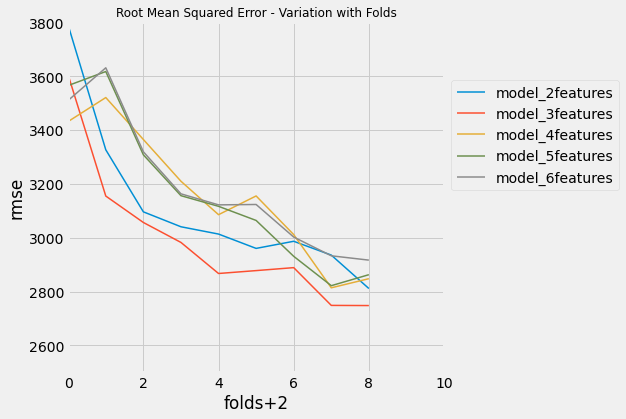

In [122]:
fig = plt.figure(figsize=(6, 6))
plt.style.use('fivethirtyeight')
models = ['model_2features', 'model_3features', 'model_4features', 'model_5features', 'model_6features']
for rmse, model in zip(models_rmse, models):
    plt.plot(rmse, label = model, linewidth = 1.5)
plt.xlabel("folds+2")
plt.ylabel('rmse')
plt.title('Root Mean Squared Error - Variation with Folds', fontsize = 12)
plt.xlim(0, 10)
plt.ylim(2500, 3800)
plt.legend(loc = 'lower left', bbox_to_anchor=(1, 0.5))
plt.show()  

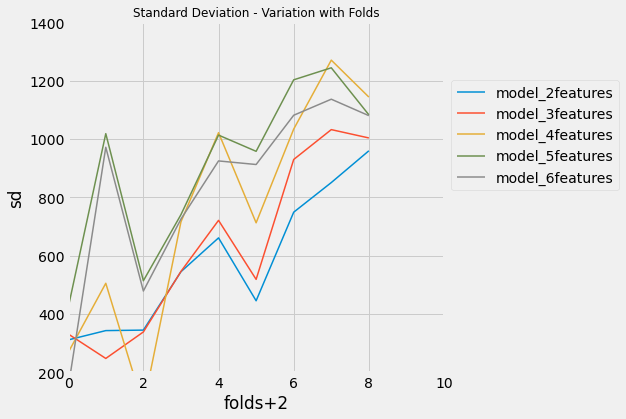

In [121]:
fig = plt.figure(figsize=(6, 6))
plt.style.use('fivethirtyeight')
models = ['model_2features', 'model_3features', 'model_4features', 'model_5features', 'model_6features']
for sd, model in zip(models_sd, models):
    plt.plot(sd, label = model, linewidth = 1.5)
plt.xlabel("folds+2")
plt.ylabel('sd')
plt.title('Standard Deviation - Variation with Folds', fontsize = 12)
plt.xlim(0, 10)
plt.ylim(200, 1400)
plt.legend(loc = 'lower left', bbox_to_anchor=(1, 0.5))
plt.show()  

### Conclusions - K-Fold Cross-Validation - Optimum Splitting Strategy

**Note**: In the above cross-validation plots, value of 0 on x-axis implies 2 folds due to quircks of our function. +2 to be added to each value, thus 8 implies 10 folds.

We can see that all five models tend to converge at an RMSE of approximately **2800-3200** corresponding to a minimum variance at a 7 folds split. Therefore this is the optimum splitting strategy between training and test data for this dataset i.e. **85% : 15%** between **training_set : test_set** 

### Conclusion

In this project we tried to predict car prices from a relatively small dataset (approx 200 entries) containing various attributes. We can conclude that:

- **Feature Selection**: It is important to select the relevant features. We can see above that our best performing models had 3 and 2 important features respectively.
- **Hyperparameter Optimization**: With a relatively small dataset with a lot of variance, we have seen that increasing knn values had the opposite effect i.e. increase in root mean squared error. This is to be expected because the number of categories in this dataset were relatively large as compared to the number of entries in that category. However, we obtained best results around a knn value of 4 and 5.
- **Data Splitting and Randomization**: The way the data is split between training and test sets or randomized can change results. It is impportant to carryout a multi-fold cross-validation in order to determine the best splitting strategy to reduce ordering bias as well as variance.